# Salton Sea Population Changes Over Time

A key question in our analysis is how has the environmental disaster impacted the local population and spured outbound population migration. Because this issue has been relatively longstanding, we would ideally be able to utilize data from as far back as 1975. The United States Census Bureau, while conducting a decenial census for several centuries, has only conducted the yearly American Community Survey (ACS) since 2005. Even data from the decenial census does not offer API access to data before 2000. For the sake of this notebook we explore ACS 5 year estimates, available from 2009 to the present day. The goal of this analysis is to explore the change in the population surrounding the Salton sea over this period.

For the purposes of this first assignment, and to develop a methodology, I look at the total population change over time. In the future, a similar process could be applied to other census variables. 

Method:
- Pull data:
    - yealy list
    - county list
    Expected output: DFs with tracts from both counties by year
- Create longitudinal DFs by variable (total population year to year, etc)
- Calculate year to year change (absolute and percentage)

In [116]:
import numpy as np
import pandas as pd
import geopandas as gpd

import requests
import json

Before we begin we can establish the variables and years we want to get data with:

In [117]:
#Create a dictionary with the desired acs variables and meaningful variable names for pulling data from the api and renaming columns.
#Available variables for the api can be found at: https://api.census.gov/data/2019/acs/acs5/variables.html

variables = {
    'B02001_001E': 'total_pop',
    'B01001I_001E': 'pop_hispanic', # variable from the sex by age table since hispanics are not disagregated in the race table published in the ACS
    'B02001_002E': 'pop_white', 
    'B02001_003E': 'pop_black',
    'B02001_004E': 'pop_nativeamerican',
    'B02001_005E': 'pop_asian',
    'B02001_006E': 'pop_pacificislander',
    'B02001_007E': 'other'}

years = list(range(2009,2022)) # Create list of years of interest to loop by to collect data

Now that we have done this, we can make api calls to get the data from the census. Because we want to get data from both Imperial and Riverside Counties, as well as for a number of years, we do this in a for loop that generates a yearly dataframe of the variables we are after and that includes both counties' census tracts. Because it will set us up for future success we also create a column in each dataframe that has a string field with the fips code we want.



In [118]:
### What follows is a loop that will loop the selected years of data and make the api calls to the census for the selected variables and output yearly dataframes

for year in years: 
    imperial_url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{','.join([x for x in variables.keys()])}&for=tract:*&in=state:06&in=county:025"
    riverside_url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{','.join([x for x in variables.keys()])}&for=tract:*&in=state:06&in=county:065"

    r_imp = requests.get(imperial_url) # pull the data for imperial county
    r_riv = requests.get(riverside_url) # pull the data for riverside county

    imp_data = r_imp.json() #take request and format it as a json to read as a df
    riv_data = r_riv.json()

    imp_df = pd.DataFrame(imp_data[1:], columns=imp_data[0]).rename(columns=variables) # create dataframe from the json objects with the first list as the column names and rename to meaningful variables
    riv_df = pd.DataFrame(riv_data[1:], columns=riv_data[0]).rename(columns=variables)

    imp_df['fips'] = imp_df['state']+imp_df['county']+imp_df['tract'] # Creates fips code from fips code parts, which works because the data is already a string
    riv_df['fips'] = riv_df['state']+riv_df['county']+riv_df['tract']


    df_list = [imp_df, riv_df] # create list of dataframes, necessary to concatenate the two counties

    globals()['df_%s' % year] = pd.concat(df_list, ignore_index=True) #combine data from both counties to one df and name it by year

It looks like it worked, so let's check how it went with the head method to get a preview of the data:

In [119]:
df_2021.head()

,NAME,total_pop,pop_hispanic,pop_white,pop_black,pop_nativeamerican,pop_asian,pop_pacificislander,other,state,county,tract,fips
0,"Census Tract 101.01, Imperial County, California",4207,2591,368,1066,113,37,10,2233,06,025,010101,06025010101
1,"Census Tract 101.02, Imperial County, California",3903,3159,2587,340,0,141,31,285,06,025,010102,06025010102
2,"Census Tract 102, Imperial County, California",2765,2416,1127,13,0,11,0,1321,06,025,010200,06025010200
3,"Census Tract 103, Imperial County, California",918,515,644,1,0,0,3,113,06,025,010300,06025010300
4,"Census Tract 104.01, Imperial County, California",2346,2227,1027,3,3,13,7,485,06,025,010401,06025010401


Looks great! How many census tracts are there?

In [120]:
df_2021.shape

(558, 13)

It looks like in 2021 there were 558 census tracts in those two counties that we are interested in. Lets see some more detail

In [121]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NAME                 558 non-null    object
 1   total_pop            558 non-null    object
 2   pop_hispanic         558 non-null    object
 3   pop_white            558 non-null    object
 4   pop_black            558 non-null    object
 5   pop_nativeamerican   558 non-null    object
 6   pop_asian            558 non-null    object
 7   pop_pacificislander  558 non-null    object
 8   other                558 non-null    object
 9   state                558 non-null    object
 10  county               558 non-null    object
 11  tract                558 non-null    object
 12  fips                 558 non-null    object
dtypes: object(13)
memory usage: 56.8+ KB


We have fips codes which is great! All of the data is an object, which may cause some problems soon when we do math, but we can cross that bridge when we come to it. For now, we want to join population years into one df.

In [122]:
yearly = df_2009.set_index('fips')[['NAME','county', 'total_pop']] # Create initial dataframe with 2009 data to join to
dfs_to_loop = [df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021] #Establish Dfs to loop through and join

for x,y in zip(dfs_to_loop, years[1:]): #Creates a loop with the dataframes and the necessary years to create one df with the columns we'd like
    yearly = yearly.join(x.set_index('fips')['total_pop'], how='outer', rsuffix=f'_{y}') # joins on fips code, and creates a suffix for the new data based on the year

yearly.rename(columns={'total_pop':'total_pop_2009'}, inplace=True) # adds the year suffix to the 2009 data that had been missing it before.

The loop ran so lets take a look with the head method again!

In [123]:
yearly.head()

,NAME,county,total_pop_2009,total_pop_2010,total_pop_2011,total_pop_2012,total_pop_2013,total_pop_2014,total_pop_2015,total_pop_2016,total_pop_2017,total_pop_2018,total_pop_2019,total_pop_2020,total_pop_2021
fips,,,,,,,,,,,,,,,
06025010100,"Census Tract 101, Imperial County, California",025,9700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06025010101,NaN,NaN,NaN,4505,4420,4412,4440,4343,4373,4223,4077,4047,4137,4254,4207
06025010102,NaN,NaN,NaN,8675,6988,7620,7682,7546,4631,4655,4564,4197,4108,4149,3903
06025010200,"Census Tract 102, Imperial County, California",025,1956,2024,2099,1988,1981,2167,2177,2397,2704,2995,2728,3108,2765
06025010300,"Census Tract 103, Imperial County, California",025,1013,1100,1073,1000,869,1010,1017,1115,1166,1172,1046,1046,918


Looks good! Now we need to create numeric columns to perform numeric operations and graphing. Pandas has a great built in method for this: pd.to_numeric and we just need to apply it. We can check if this worked by applying the info() method.

In [124]:
columns_to_number = ['total_pop_2009', 'total_pop_2010', 'total_pop_2011', # Create a list of the columns to apply things to
       'total_pop_2012', 'total_pop_2013', 'total_pop_2014', 'total_pop_2015',
       'total_pop_2016', 'total_pop_2017', 'total_pop_2018', 'total_pop_2019',
       'total_pop_2020', 'total_pop_2021']
yearly[columns_to_number] = yearly[columns_to_number].apply(pd.to_numeric) # apply the pandas method to the columns we want and overwrite those columns

yearly.info() # check if it worked!

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 06025010100 to 06065981000
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NAME            372 non-null    object 
 1   county          372 non-null    object 
 2   total_pop_2009  372 non-null    float64
 3   total_pop_2010  484 non-null    float64
 4   total_pop_2011  484 non-null    float64
 5   total_pop_2012  484 non-null    float64
 6   total_pop_2013  484 non-null    float64
 7   total_pop_2014  484 non-null    float64
 8   total_pop_2015  484 non-null    float64
 9   total_pop_2016  484 non-null    float64
 10  total_pop_2017  484 non-null    float64
 11  total_pop_2018  484 non-null    float64
 12  total_pop_2019  484 non-null    float64
 13  total_pop_2020  558 non-null    float64
 14  total_pop_2021  558 non-null    float64
dtypes: float64(13), object(2)
memory usage: 90.5+ KB


Success! Now we can graph and map things! 

lets start with graphing one of the tracts over time on a line graph

In [125]:
yearly.columns = ['Name', 'county', 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] # rename columns to easier to see and label names

<AxesSubplot:>

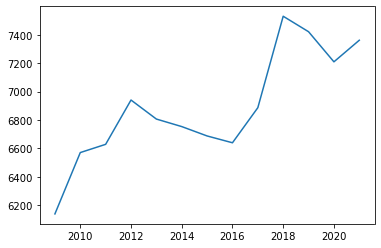

In [126]:
yearly[years].transpose()['06025010500'].plot.line() # select necessary columns, transpose the data to a vertical format for plotting, select tract, and plot

Overall this tract has seen population growth, with a dip in in the mid 2010s. What has it looked like overal?

<AxesSubplot:>

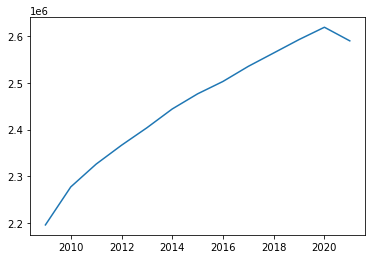

In [127]:
yearly[years].agg(sum).plot.line() # select necessary columns, aggregate as a sum, and plot

There seems to be a steady growth in population until 2020, maybe there was a change in how census boundaries were drawn?

Let's map the populaiton in 2021 to see where it was distributed. First we need to read in a shape file with census tract geometry, then we can join the data to it and make a map.

Note that GitHub will not accept large files and as such the tigerline shapefile is not uploaded to our repository at this time since it's total size is >50 mb. 

In [128]:
gdf = gpd.read_file('data/tl_2022_06_tract/tl_2022_06_tract.shp', epsg='4326') # read census tigerline shape file (2022)
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,137504,06037137504,1375.04,Census Tract 1375.04,G5020,S,3837562,0,+34.1480383,-118.5720594,"POLYGON ((-118.58119 34.14318, -118.58099 34.1..."
1,06,037,138000,06037138000,1380,Census Tract 1380,G5020,S,4472196,0,+34.1488008,-118.5910495,"POLYGON ((-118.60573 34.14585, -118.60561 34.1..."
2,06,037,139200,06037139200,1392,Census Tract 1392,G5020,S,1152028,0,+34.1756961,-118.5246446,"POLYGON ((-118.53082 34.18024, -118.52952 34.1..."
3,06,087,120901,06087120901,1209.01,Census Tract 1209.01,G5020,S,18372491,0,+37.0781624,-122.0154263,"POLYGON ((-122.04607 37.07105, -122.04505 37.0..."
4,06,087,120902,06087120902,1209.02,Census Tract 1209.02,G5020,S,6474889,0,+37.0628452,-122.0106243,"POLYGON ((-122.02513 37.04320, -122.02500 37.0..."


In [129]:
gdf.set_index('GEOID', inplace=True) # set index to fips code, useful for the join
gdf = gdf.join(yearly, how='right') # join the data and keep only a record for each tract we have data for
gdf.head() # see if it worked

,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
fips,,,,,,,,,,,,,,,,,,,,,
06025010100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06025010101,06,025,010101,101.01,Census Tract 101.01,G5020,S,379172003.0,954069.0,+33.1874151,...,4412.0,4440.0,4343.0,4373.0,4223.0,4077.0,4047.0,4137.0,4254.0,4207.0
06025010102,06,025,010102,101.02,Census Tract 101.02,G5020,S,233852830.0,189009524.0,+33.2254028,...,7620.0,7682.0,7546.0,4631.0,4655.0,4564.0,4197.0,4108.0,4149.0,3903.0
06025010200,06,025,010200,102,Census Tract 102,G5020,S,187539094.0,36114014.0,+33.0633411,...,1988.0,1981.0,2167.0,2177.0,2397.0,2704.0,2995.0,2728.0,3108.0,2765.0
06025010300,06,025,010300,103,Census Tract 103,G5020,S,467707929.0,338212.0,+32.9827303,...,1000.0,869.0,1010.0,1017.0,1115.0,1166.0,1172.0,1046.0,1046.0,918.0


The join seems to have worked! There were at least a few tracts that no longer exist but we can map those that we have geometry for

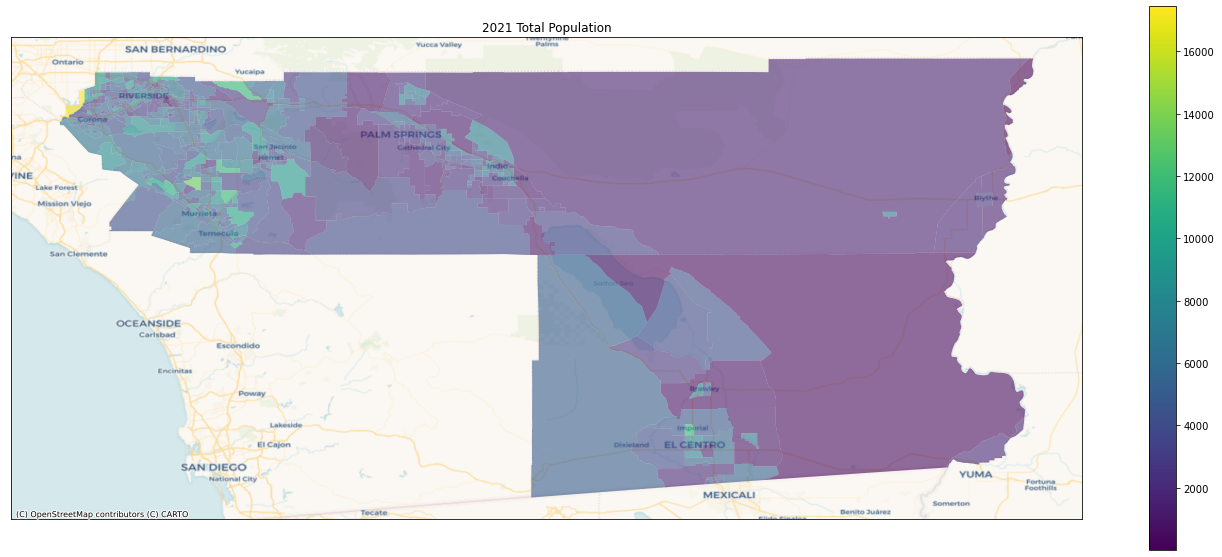

In [130]:
import matplotlib.pyplot as plt # import plotting library for better options
import contextily as ctx # import basemap options

fig, ax = plt.subplots(figsize=(24, 10)) # set figure frame size to better suite the map
gdf.plot(2021, ax = ax, legend=True, alpha=0.6) # create plot with 2021 data and set opacity to .6 to see where the salton sea is.

# remove the tick labels
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('2021 Total Population') # Create a title for the map
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager) # set a basemap to see more context

We have a map! Most of the population is not near the Salton sea, it is more concentrated towards the larger cities and populaiton centers. We'll have to explore this further!